# Search Token Prediction
-----

## Table of Contents:
* [Data Cleaning and Preprocessing](#data-clean)
    * [Bias and Noise](#data-bias)
    * [Lemmatization](#data-lemma)
    * [Encoding](#data-encoding)
    * [Sequences](#model-sequences)
* [Model](#model) 
    * [Architecture](#model-selection)
    * [Loss Function](#model-loss)
* [Future Work](#future)

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
import nltk
# Uncomment to download stopwords
# nltk.download('stopwords')
# Uncomment to download Lemmatizer related package
# nltk.download('averaged_perceptron_tagger')
# Uncomment to download wordnet
# nltk.download('wordnet')
import pickle
import matplotlib as mt
import matplotlib.pyplot as plt
plt.style.use('classic')
# Interactive Tools for Matplotlib
%matplotlib notebook
%matplotlib inline

# from sklearn.manifold import TSNE
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
# map words to integers
from sklearn.preprocessing import LabelEncoder

## <a name="data-clean"></a>Data Cleaning and Preprocessing
-----------------------

In [6]:
# Pre-saved and pre-trained models and data set.
# If using these, skip to the section on `Prediction`.

# Uncomment to load small sequence data. You can then skip to `Model` section.
sequences = np.load('data/seqs/seq.np.npy')

# Uncomment to load the preprocessed data set
# df = pd.read_csv('data/processed.csv')

# Uncomment to load the label encoder
with open('models/tokenizer.p', 'rb') as f:
    le = pickle.load(f)

# Uncomment to load the language model
# with open('models/language.p', 'rb') as f:
#     model = pickle.load(f)

In [16]:
# Load the data set. Consider lazy loading 
# due to the large file size
df = pd.read_csv('data/search_log.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103913566 entries, 0 to 103913565
Data columns (total 3 columns):
key       object
time      int64
userId    int64
dtypes: int64(2), object(1)
memory usage: 2.3+ GB


### <a name="data-bias"></a>Bias and Noise

In [17]:
# Drop data rows with undefined keys.
# Note: As an alternative to dropping rows with undefined keys,
#       we could try to impute the undefined values by sampling 
#       from the conditional (on userId) distribution of keys.
df = df.dropna(subset=['key'])
# In a general corpus of text, stopwords dominate
# histogram counts, causing biased word frequency counts. 
# For this reason, we remove stopwords from language models.
df = df[~df['key'].isin(stopwords.words('english'))]

In [5]:
df.isnull().any()

key       False
time      False
userId    False
dtype: bool

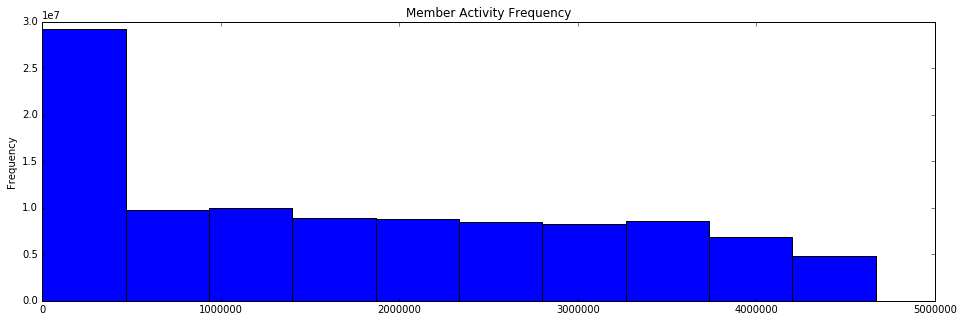

In [6]:
f, ax = plt.subplots(1, figsize=(16, 5))

# Check for selection bias
df['userId'].plot(kind='hist', ax=ax, title='Member Activity Frequency')

* There is a clear bias towards one of the early members.

In [7]:
# Remove search tokens of outlier users
counts = df.groupby(df.userId).count()

In [8]:
counts = counts.sort_values(by='key', ascending=False)
counts.head()

,key,time
userId,,
1,19542524,19542524
1672434,29163,29163
198364,16264,16264
3655782,15806,15806
2890254,15182,15182


User with id 1 has orders of magnitude more search queries than anyone else. This user is likely an automated system
or a team of iternal developers running tests. We remove this row from the data set to avoid this bias.

In [19]:
df = df[df.userId != 1]

### <a name="data-lemma"></a>Lemmatization

In [20]:
# Lemmatizing words bring them to a canonical form by factoring out the stem, 
# converting pos types (noun, verb, etc..) to a specified pos tag, as well 
# as lowering the cases.
wnl = WordNetLemmatizer()
pos_translate = {'J':'a', 'V':'v', 'N':'n', 'R':'r'}
fn = lambda key: wnl.lemmatize(key, pos='n')
df['key'] = df['key'].apply(fn)

In [12]:
df[df['userId'] == int(2e6)].sort_values(by='time').head(10)

,key,time,userId
43794838,wings free,17406560,2000000
43794839,wing,17406617,2000000
43794840,wings free,17406984,2000000
43794841,butterfly wings,17407482,2000000
43794842,butterfly wings,17407556,2000000
43794843,wing,17409994,2000000
43794844,fairy wings,17410392,2000000
43794845,fairy wings,17437090,2000000
43794846,mermaid,17437185,2000000
43794847,mermaid,17437381,2000000


### <a name="data-encoding"></a>Encoding

In [21]:
# Generate a mapping from word to integer
# e.g. f('hello') -> 1
le = LabelEncoder()
df['embedding'] = le.fit_transform(df['key'])
# Uncomment to save the tokenizer
# with open('models/tokenizer.p', 'wb') as f:
#     pickle.dump(le, f)
df.head()

,key,time,userId,embedding
19563559,heart,41369281,2,969498
19563560,heart,41369388,2,969498
19563561,heart,41369687,2,969498
19563562,heart,41369765,2,969498
19563563,heart,41369822,2,969498


In [22]:
# Having a trained encoder for words,
# we can safely delete the `key` column from the data set.
if 'key' in df.columns:
    df = df.drop('key', axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 84260377 entries, 19563559 to 103913565
Data columns (total 3 columns):
time         int64
userId       int64
embedding    int64
dtypes: int64(3)
memory usage: 2.5 GB


In [23]:
# Uncomment to save the preprocessed data set.
# df.to_csv('data/processed.csv')

### <a name="model-sequences"></a>Sequences

A key design decision is how long the input sequences should be. They need to be long enough to allow the model to learn the context for the words to predict. We will use sequences of length 50.

**Note: The number of generated sequences will be very large, and a much better idea is to store it using the [HDF5](https://support.hdfgroup.org/HDF5/) format. For the sake of this example, we sample user data.**

In [ ]:
# Sequences length 
seq_length = 50
# number of sampled users
N = 100
idx = np.random.choice(np.arange(df['userId'].median(),df['userId'].max()), size=N, replace=False)
idx = idx.astype(int)

In [5]:
sequences = []
# sample users
tokens = df[df['userId'].isin(idx)]

tokens = tokens.sort_values(by='time')
groups = tokens.groupby('userId')

for id, group in groups:
    # organize into sequences of tokens
    for i in range(seq_length+1, len(group)):
        # select sequence of tokens
        seq = group['embedding'].iloc[i-seq_length:i].values
        # store
        sequences.append(seq)

# Uncomment to save the sequences
# np.save('data/seqs/seq.np', sequences)      

print('Total Sequences: %d' % len(sequences))

sequences = np.array(sequences)

Total Sequences: 1270


## <a name="model"></a>Model
----

In [3]:
from keras.models import Model, Sequential
from keras.layers import GRU, Dense
from keras.layers import Input, LSTM, Dense, Embedding
from keras.optimizers import Adam

### <a name="model-selection"></a>Architecture

We will use a sequence to word model that learns a conditional distribution
of a word given a sequence of previous words.

$$P(w_{N}\mid w_{N-1}, w_{N-2}, ..., w_{N-m}) = f(w_{N-1}, w_{N-2}, ..., w_{N-m})$$

The predicted word will be fed in as input to in turn generate the next word.

The model we will train is a neural language model. It has a few unique characteristics:

* It uses a distributed representation for words so that different words with similar meanings will have a similar representation.
* It learns the representation at the same time as learning the model.
* It learns to predict the probability for the next word using a context of previous words.
* Specifically, we will use an Embedding Layer to learn the representation of words, and a Long Short-Term Memory (LSTM) recurrent neural network to learn to predict words based on their context.

In [14]:
def build_rnn(embedding_shape,
              Cell=GRU, 
              Layers=1,
              Dropout=0.,
              Hidden=25,
              outdim=1,
              activation="softmax"):
    """
    Constructor for a multilayer recurrent network.
    
    :params embedding_shape tuple: (vocab_size, out_dim, seq_length)
    :params Cell str: Type of cell unit used in the model (gru, lstm...)
    :params Layers int: The number of hidden recurrent layers
    :params Dropout float: Probability of Dropout [0; 1]
    :params outdim int: dimension of output data. Default (1) regresses to 
                        a single value.
    :param activation str: final activation layer type (e.g. "linear")
    """
    
    model = Sequential()
    # Start with an embedding layer to convert sparse word vectors to dense ones.
    vocab_size, out_dim, seq_length = embedding_shape
    model.add(Embedding(vocab_size, out_dim, input_length=seq_length))
    
    # If the model has more than one recurrent layer,
    # output all the sequences (not just the final one).
    if Layers > 1:
        return_sequences = True
    else:
        return_sequences = False
        
    # The first layer requires `input_shape` to be specified.
    model.add(Cell(Hidden, 
                   return_sequences=return_sequences,
                   # input_shape=input_shape,
                   dropout=Dropout,
                   recurrent_dropout=Dropout))

    # Input shapes are inferred in the subsequent layers
    for layer in range(Layers - 1):
        # Make sure the final hidden layer does not output all the sequences.
        if layer == Layers - 2:
            return_sequences = False
        model.add(Cell(Hidden,
                       return_sequences=return_sequences, 
                       dropout=Dropout,
                       recurrent_dropout=Dropout))
    
    # Add a final dense layer
    model.add(Dense(outdim, activation=activation))
    
    return model


embedding_shape = (len(le.classes_)+1, 50, seq_length)
model = build_rnn(
    embedding_shape=embedding_shape,
    Cell=LSTM,
    Layers=2,
    # Ensure that model has enough capacity first
    Dropout=0.,
    Hidden=100,
    outdim=len(le.classes_)
)

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 49, 50)            118679850 
_________________________________________________________________
lstm_3 (LSTM)                (None, 49, 100)           60400     
_________________________________________________________________
lstm_4 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_2 (Dense)              (None, 2373596)           239733196 
Total params: 358,553,846
Trainable params: 358,553,846
Non-trainable params: 0
_________________________________________________________________
None


In [15]:
# separate into input and output
X, y = sequences[:,:-1], sequences[:,-1]
y = keras.utils.to_categorical(y, num_classes=len(le.classes_))
seq_length = X.shape[1]

### <a name="model-loss"></a>Loss Function (example run)

Since the model learns a conditional probability distribution, we will **categorical cross-entropy** as the measure of loss.

In [16]:
# compile model
model.compile(
    loss='categorical_crossentropy', 
    # Use tensorflow optimizers to avoid the conversion from sparse
    # gradients to dense gradients due the Embedding layer. This can
    # have a devastating effect on performance.
    optimizer=tf.train.AdamOptimizer(), metrics=['accuracy'])
# fit model
model.fit(X, y, batch_size=128, epochs=1)

Epoch 1/1
1270/1270 [==============================] - 570s 449ms/step - loss: 14.6719 - acc: 0.0890


## <a name="future"></a>Future Work
---------------

* Split the `keys` with more than one word into separate entries.
* Experiment with more (fewer) number of recurrent layers.
* Experiment with type of recurrent layers (GRU, etc...).
* Use sklearn's `GridSearchCV` to tune hyperparameters (learning rate, etc...).
* Use sklearn's `TimeSeriesSplit` to cross validate the time series data.
* Run a full training session (with all the sequneces) on a GPU powered Amazon EC2 cluster.
* Compare the performance of the recurrent neural network to an ARIMA model.